# EDA for traffic violations dataset

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import re, difflib
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Traffic_Violations.csv')

C:\Users\diazk\AppData\Local\Temp\ipykernel_3540\4096515456.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Traffic_Violations.csv')


In [45]:
# size before filtering
before = len(df)

# find the 254 most common charges
top_254 = df['Charge'].value_counts().nlargest(255).index

# filter DF to only those charges
df_filtered = df[df['Charge'].isin(top_254)].copy()

# size after filtering
after = len(df_filtered)

print("Before:", before)
print("After:", after)


Before: 1018634
After: 1003332


In [5]:
geo_df = df[["Latitude", "Longitude"]].dropna().sample(10000, random_state=42)

px.density_map(
    geo_df,
    lat='Latitude',
    lon='Longitude',
)

In [6]:
df['Make'].unique().tolist()

['FORD',
 'AUDI',
 'TOYT',
 'HONDA',
 'CHEVROLET',
 'DODGE',
 'INFINITY',
 'HYUNDAI',
 'NISSAN',
 'CADI',
 'NONE',
 'TOYOTA',
 'CADILLAC',
 'SATURN',
 'HOND',
 'ACUR',
 'LEXUS',
 'GILL',
 'PONTIAC',
 'JEEP',
 'MERCEDES',
 'BUICK',
 'MITSUBISHI',
 'ACURA',
 'KAWASAKI',
 'CHEV',
 'CHRY',
 'MAZDA',
 'KIA',
 'INFI',
 'SUNNY',
 'LINCOLN',
 'SUBARU',
 'WV',
 'HYUNDA',
 'GMC',
 'FIAT',
 'NISS',
 'BMW',
 'OLDS',
 'MITS',
 'PONT',
 'TOYOT',
 'CHRYSLER',
 'CHEVY',
 'MERZ',
 'LNDR',
 'SUBRARU',
 'LINC',
 'SATR',
 'LANDROVER',
 'TOY',
 'INFINITI',
 'MERCURY',
 'XX',
 'SAAB',
 'VOLV',
 'DODG',
 'CRUZ',
 'VOLK',
 'HYANDAI',
 'HYUN',
 'MERC',
 'HUMMER',
 'MITSUBUSHI',
 'SATU',
 'SCION',
 'BUIC',
 'GEO',
 'RANGE ROVER',
 'MAZD',
 'SUBA',
 'PLYMOUTH',
 'M BENZ',
 'KAW',
 'CHEVEROLET',
 '2004',
 'UNKNOWN',
 'BENTLEY',
 'HYNDAI',
 'VOLKSWAGON',
 'OLDSMOBILE',
 'MERCEDEZ',
 'MAZADA',
 'RIELLA',
 'HARLEY DAVIDSON',
 'HYUNDIA',
 'GRUMAN',
 'TOYO',
 'IZUZU',
 'BIGT',
 'VOLVO',
 'VW',
 'JAGUAR',
 'PTRB',
 'CR

Will need to do data cleanup on the Make of the vehicles

In [7]:
canonical_makes = [
    "ACURA","ALFA ROMEO","ASTON MARTIN","AUDI","BENTLEY","BMW","BUGATTI","BUICK",
    "CADILLAC","CHEVROLET","CHRYSLER","DODGE","FERRARI","FIAT","FORD","GENESIS","GMC",
    "HONDA","HUMMER","HYUNDAI","INFINITI","ISUZU","JAGUAR","JEEP","KIA","LAMBORGHINI",
    "LAND ROVER","LEXUS","LINCOLN","MASERATI","MAZDA","MERCEDES-BENZ","MERCURY","MINI",
    "MITSUBISHI","NISSAN","OLDSMOBILE","PEUGEOT","PLYMOUTH","PONTIAC","PORSCHE","RAM",
    "RENAULT","ROLLS-ROYCE","SAAB","SATURN","SCION","SMART","SUBARU","SUZUKI","TESLA",
    "TOYOTA","VOLKSWAGEN","VOLVO",

    "MACK","FREIGHTLINER","PETERBILT","KENWORTH","HINO","INTERNATIONAL",
    "HARLEY DAVIDSON","KAWASAKI","YAMAHA",

    "NONE", "NA", 
]

alias_map = {
    # --- Toyota ---
    "TOYOT":"TOYOTA","TOYTA":"TOYOTA","TOYO":"TOYOTA","TOYT":"TOYOTA",
    "TOTY":"TOYOTA","TYT":"TOYOTA",

    # --- Hyundai ---
    "HYANDAI":"HYUNDAI","HYUNDIA":"HYUNDAI","HYUNDI":"HYUNDAI","HYND":"HYUNDAI",

    # --- Mercedes-Benz ---
    "MERC":"MERCEDES-BENZ","MERZ":"MERCEDES-BENZ","MERZ BENZ":"MERCEDES-BENZ",
    "MB":"MERCEDES-BENZ","M B":"MERCEDES-BENZ","M-B":"MERCEDES-BENZ","BENZ":"MERCEDES-BENZ",
    "MERCEDES":"MERCEDES-BENZ","MERCEDES BENZ":"MERCEDES-BENZ","MERCDES":"MERCEDES-BENZ",

    # --- Chevrolet ---
    "CHEV":"CHEVROLET","CHEVY":"CHEVROLET","CHEVEROLET":"CHEVROLET","CHV":"CHEVROLET",
    "CHE":"CHEVROLET",

    # --- Infiniti ---
    "INF":"INFINITI","INFINITY":"INFINITI","INFIN":"INFINITI",

    # --- Lexus ---
    "LEX":"LEXUS","LEXSUS":"LEXUS","LEXS":"LEXUS",

    # --- Mitsubishi ---
    "MITS":"MITSUBISHI","MITZ":"MITSUBISHI","MITUSBISHI":"MITSUBISHI","MISUBISHI":"MITSUBISHI",
    "MITUBISHI":"MITSUBISHI","MITUSB":"MITSUBISHI",

    # --- Oldsmobile ---
    "OLDS":"OLDSMOBILE","OLDSMOB":"OLDSMOBILE","OLDSM":"OLDSMOBILE",

    # --- Land Rover ---
    "LNDR":"LAND ROVER","RANG":"LAND ROVER","RANGE":"LAND ROVER","RANGE ROVER":"LAND ROVER",
    "LANDROVER":"LAND ROVER",

    # --- Dodge / Chrysler ---
    "DODG":"DODGE","CRYSLER":"CHRYSLER","CHRSYLER":"CHRYSLER","CHR":"CHRYSLER",

    # --- Honda ---
    "HOND":"HONDA","HON":"HONDA",

    # --- Volkswagen ---
    "VW":"VOLKSWAGEN","VOLKS":"VOLKSWAGEN","VOLKSWAGON":"VOLKSWAGEN","WOLKSWAGEN":"VOLKSWAGEN",
    "VOLLKSWAGEN":"VOLKSWAGEN","VOLKW":"VOLKSWAGEN",

    # --- Cadillac ---
    "CAD":"CADILLAC","CADI":"CADILLAC","CADDY":"CADILLAC",

    # --- Nissan ---
    "NIS":"NISSAN","NISN":"NISSAN","NISS":"NISSAN",

    # --- Subaru ---
    "SUB":"SUBARU","SUBA":"SUBARU",

    # --- Ford ---
    "FRD":"FORD","FD":"FORD",

    # --- GMC ---
    "GM":"GMC","G M C":"GMC",

    # --- Mazda ---
    "MAZD":"MAZDA",

    # --- Genesis ---
    "GEN":"GENESIS","GENSIS":"GENESIS",

    # --- Porsche ---
    "PORSHE":"PORSCHE","POR":"PORSCHE",

    # --- Tesla ---
    "TSLA":"TESLA",

    # --- Harley-Davidson ---
    "HARLEY":"HARLEY DAVIDSON","HARLEY-DAVIDSON":"HARLEY DAVIDSON","HARL":"HARLEY DAVIDSON",

    # --- Yamaha ---
    "YAMA":"YAMAHA","YAM":"YAMAHA",

    # --- Kawasaki ---
    "KAW":"KAWASAKI","KAWK":"KAWASAKI",

    # --- Truck / Heavy vehicle makes ---
    "MACK":"MACK",
    "INTL":"INTERNATIONAL","INTERNATIONAL":"INTERNATIONAL",
    "FRHT":"FREIGHTLINER","FRTLN":"FREIGHTLINER","FREIGHT":"FREIGHTLINER",
    "PETE":"PETERBILT","PETERBUILT":"PETERBILT",
    "KEN":"KENWORTH","KW":"KENWORTH",
    "HINO":"HINO",

    # --- Misc abbreviations ---
    "BM":"BMW","B M W":"BMW","B.M.W":"BMW","BMW":"BMW",
    "VOLVO":"VOLVO","VOLV":"VOLVO","VO":"VOLVO",
    "JAG":"JAGUAR","JAGR":"JAGUAR",
    "LEXUS":"LEXUS","INFINITI":"INFINITI",
    "ACUR":"ACURA","ACURA":"ACURA",
    "HYUNDAI":"HYUNDAI","HONDA":"HONDA","FORD":"FORD",
}


def normalize_make(x: str) -> str:
    if not isinstance(x, str):
        return ""
    s = x.upper().strip()
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s

def resolve_make(raw: str) -> str:
    s = normalize_make(raw)
    if not s:
        return "UNKNOWN"
    if s in alias_map:
        return alias_map[s]
    if s in canonical_makes:
        return s
    first = s.split(" ")[0]
    if first in alias_map:
        return alias_map[first]
    match = difflib.get_close_matches(s, canonical_makes, n=1, cutoff=0.65)
    if match:
        return match[0]
    match = difflib.get_close_matches(first, canonical_makes, n=1, cutoff=0.65)
    return match[0] if match else "UNKNOWN"

df['Cleaned_Make'] = df['Make'].apply(resolve_make)
before_clean = df['Make'].nunique()
after_clean = df['Cleaned_Make'].nunique()
print(f"Before Cleanup: {before_clean}, After Cleanup: {after_clean}")
display(df[['Make', 'Cleaned_Make']])
display(df['Cleaned_Make'].value_counts().head(20))


Before Cleanup: 3129, After Cleanup: 64


,Make,Cleaned_Make
0,FORD,FORD
1,AUDI,AUDI
2,TOYT,TOYOTA
3,HONDA,HONDA
4,HONDA,HONDA
...,...,...
1018629,HONDA,HONDA
1018630,DODGE,DODGE
1018631,HYUN,HYUNDAI
1018632,LINC,LINCOLN


Cleaned_Make
TOYOTA           176134
HONDA            146098
FORD              97400
CHEVROLET         79986
NISSAN            77116
DODGE             35389
ACURA             31806
HYUNDAI           31411
MERCEDES-BENZ     30929
BMW               28037
LEXUS             22893
JEEP              22318
MAZDA             20534
VOLVO             18329
CHRYSLER          17570
VOLKSWAGEN        15194
MITSUBISHI        13825
GMC               13774
SUBARU            13696
KIA               12617
Name: count, dtype: int64

In [8]:
unknown_counts = (
    df.loc[df["Cleaned_Make"] == "UNKNOWN", "Make"]
      .value_counts()
      .head(30)
)
print("Top 30 unknown make entries:")
print(unknown_counts)
print(f"Total UNKNOWN entries: {unknown_counts.sum()}")


Top 30 unknown make entries:
Make
GEO          677
FREI         146
STERLING     138
INTE         115
TAO TAO      102
LAND          97
PTRB          95
THOMAS        87
CARR          84
DUCATI        71
GILL          70
ORION         63
KYMCO         58
STER          58
HUYN          58
PREM          57
DAEWOO        56
UNKNOWN       54
MIT           52
VESPA         52
UNK           50
MITTS         50
INT           49
COOPER        46
NEW FLYER     41
HYN           41
CEHVY         39
DUCA          39
HD            39
HUDSON        36
Name: count, dtype: int64
Total UNKNOWN entries: 2620


C:\Users\diazk\AppData\Local\Temp\ipykernel_3540\764847673.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



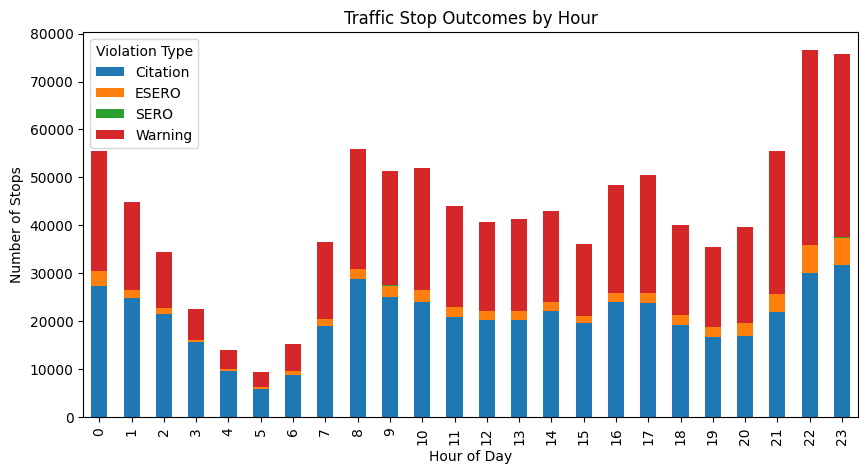

In [9]:
df["Hour"] = pd.to_datetime(df["Time Of Stop"], errors="coerce").dt.hour

hourly = df.groupby(["Hour", "Violation Type"]).size().unstack(fill_value=0)

hourly.plot(kind="bar", stacked=True, figsize=(10,5),
            title="Traffic Stop Outcomes by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Stops")
plt.legend(title="Violation Type")
plt.show()


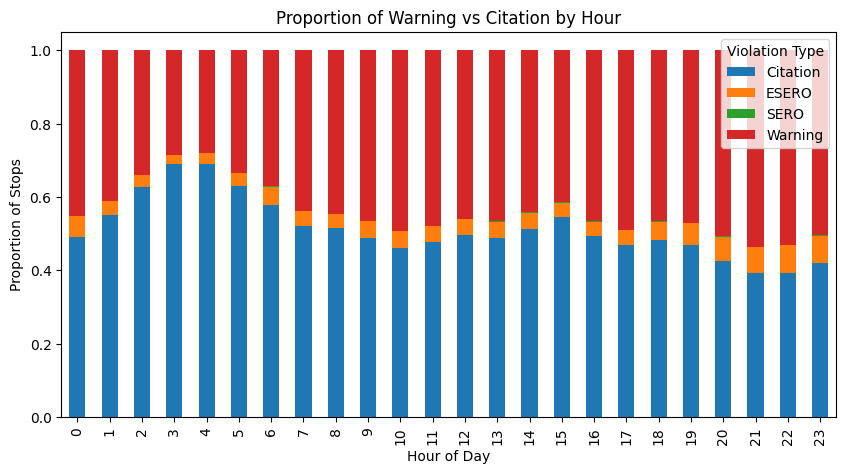

In [10]:
hourly_norm = hourly.div(hourly.sum(axis=1), axis=0)

hourly_norm.plot(kind="bar", stacked=True, figsize=(10,5),
                 title="Proportion of Warning vs Citation by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Proportion of Stops")
plt.legend(title="Violation Type")
plt.show()


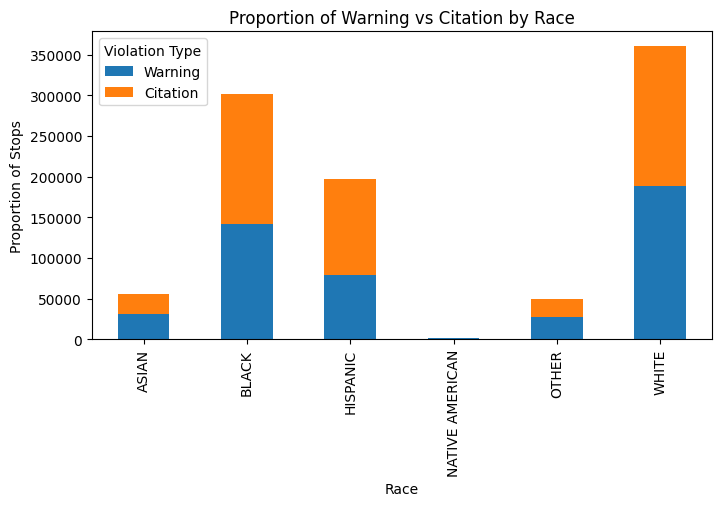

In [11]:
pd.crosstab(df["Race"], df["Violation Type"], normalize="index")

race_outcomes = df.groupby("Race")["Violation Type"].value_counts().unstack()
race_outcomes[["Warning","Citation"]].plot(kind="bar", stacked=True, figsize=(8,4))
plt.title("Proportion of Warning vs Citation by Race")
plt.ylabel("Proportion of Stops")
plt.show()


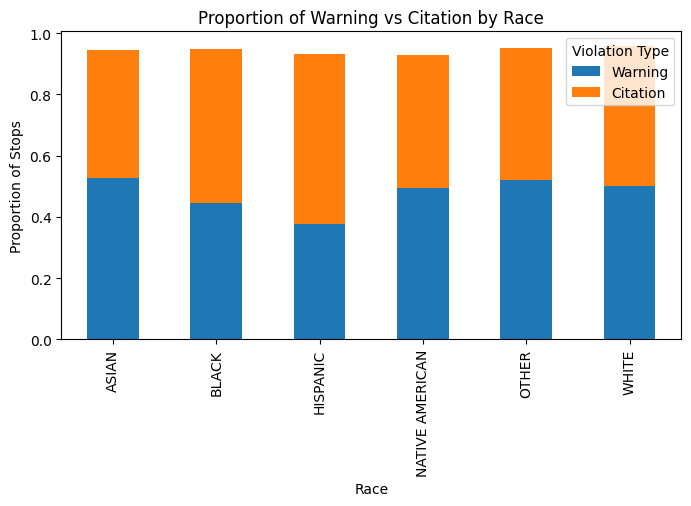

In [12]:
pd.crosstab(df["Race"], df["Violation Type"], normalize="index")

race_outcomes = df.groupby("Race")["Violation Type"].value_counts(normalize=True).unstack()
race_outcomes[["Warning","Citation"]].plot(kind="bar", stacked=True, figsize=(8,4))
plt.title("Proportion of Warning vs Citation by Race")
plt.ylabel("Proportion of Stops")
plt.show()

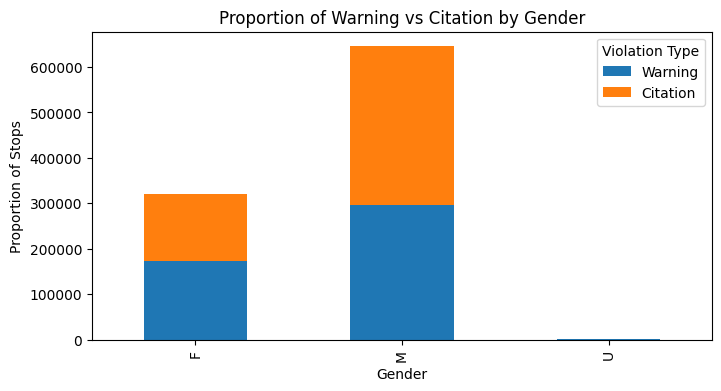

In [13]:
gender_outcomes = df.groupby("Gender")["Violation Type"].value_counts().unstack()
gender_outcomes[["Warning","Citation"]].plot(kind="bar", stacked=True, figsize=(8,4))
plt.title("Proportion of Warning vs Citation by Gender")
plt.ylabel("Proportion of Stops")
plt.show()

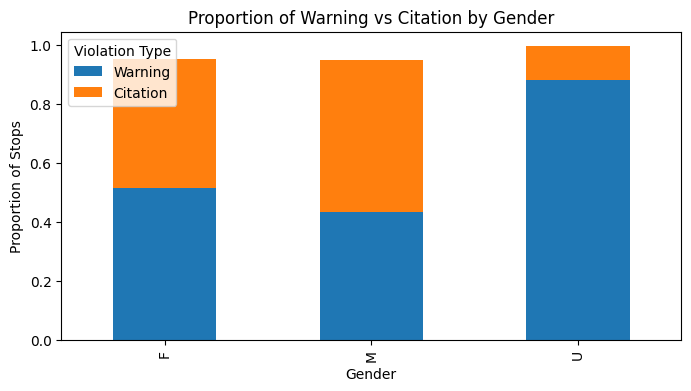

In [14]:
gender_outcomes = df.groupby("Gender")["Violation Type"].value_counts(normalize=True).unstack()
gender_outcomes[["Warning","Citation"]].plot(kind="bar", stacked=True, figsize=(8,4))
plt.title("Proportion of Warning vs Citation by Gender")
plt.ylabel("Proportion of Stops")
plt.show()

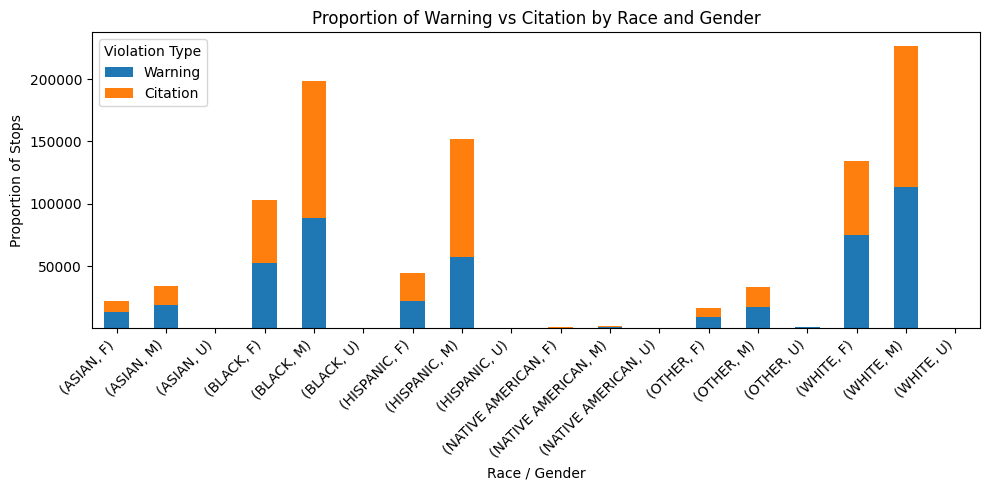

In [15]:
# Crosstab normalized within each Race–Gender group
race_gender_outcomes = pd.crosstab(
    [df["Race"], df["Gender"]],
    df["Violation Type"],
)

# Plot only Warning vs Citation
race_gender_outcomes[["Warning","Citation"]].plot(
    kind="bar",
    stacked=True,
    figsize=(10,5),
    title="Proportion of Warning vs Citation by Race and Gender"
)
plt.ylabel("Proportion of Stops")
plt.xlabel("Race / Gender")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


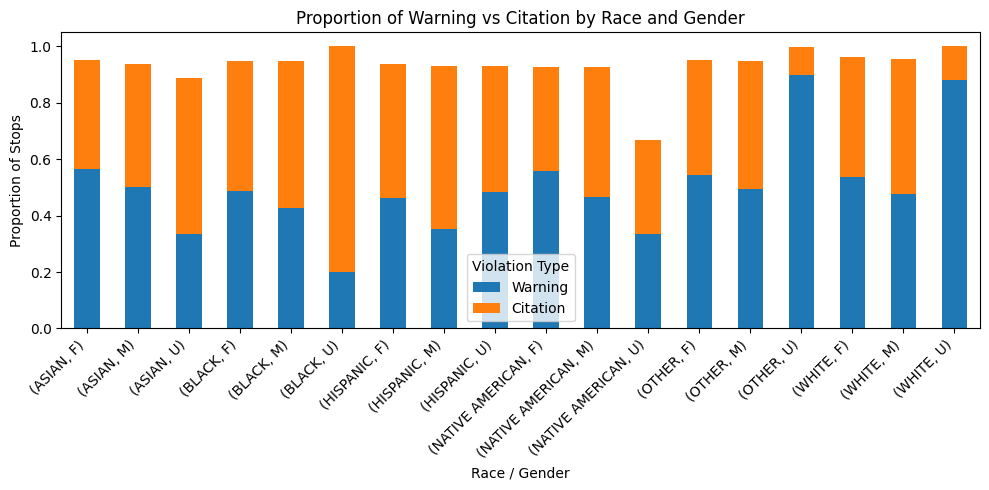

In [16]:
# Crosstab normalized within each Race–Gender group
race_gender_outcomes = pd.crosstab(
    [df["Race"], df["Gender"]],
    df["Violation Type"],
    normalize="index"
)

# Plot only Warning vs Citation
race_gender_outcomes[["Warning","Citation"]].plot(
    kind="bar",
    stacked=True,
    figsize=(10,5),
    title="Proportion of Warning vs Citation by Race and Gender"
)
plt.ylabel("Proportion of Stops")
plt.xlabel("Race / Gender")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [17]:
geo = df.dropna(subset=['Latitude', 'Longitude', 'Violation Type'])

warnings = geo[geo['Violation Type'] == 'Warning']
citations = geo[geo['Violation Type'] == 'Citation']

px.density_map(
    warnings.sample(3000, random_state=42),
    lat="Latitude", lon="Longitude",
    radius=6, zoom=9,
    title="Density of Warnings Issued",
)

In [18]:
px.density_map(
    citations.sample(3000, random_state=42),
    lat="Latitude", lon="Longitude",
    radius=6, zoom=9,
    title="Density of Citations Issued",
)

In [19]:
citation_rate = df.groupby(["Race","Gender"])["Violation Type"].apply(lambda x: (x=="Citation").mean())
citation_rate.sort_values(ascending=False)


Race             Gender
BLACK            U         0.800000
HISPANIC         M         0.580273
ASIAN            U         0.555556
BLACK            M         0.524627
WHITE            M         0.478069
HISPANIC         F         0.473631
NATIVE AMERICAN  M         0.462940
BLACK            F         0.459706
OTHER            M         0.455297
HISPANIC         U         0.448276
ASIAN            M         0.435921
WHITE            F         0.424634
OTHER            F         0.407875
ASIAN            F         0.388916
NATIVE AMERICAN  F         0.369427
                 U         0.333333
WHITE            U         0.117647
OTHER            U         0.099074
Name: Violation Type, dtype: float64

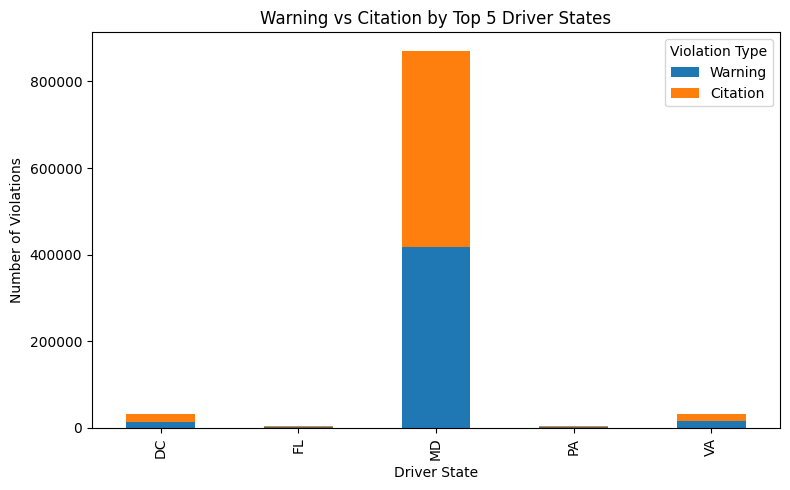

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Top 5 driver states by total violations
top_states = df["Driver State"].value_counts().head(5).index

# Filter only those states
subset = df[df["Driver State"].isin(top_states)]

# Group by state and violation type
state_violation = (
    subset.groupby(["Driver State", "Violation Type"])
    .size()
    .unstack(fill_value=0)
)

# Plot stacked bars
state_violation[["Warning","Citation"]].plot(
    kind="bar",
    stacked=True,
    figsize=(8,5),
    title="Warning vs Citation by Top 5 Driver States"
)

plt.xlabel("Driver State")
plt.ylabel("Number of Violations")
plt.tight_layout()
plt.show()


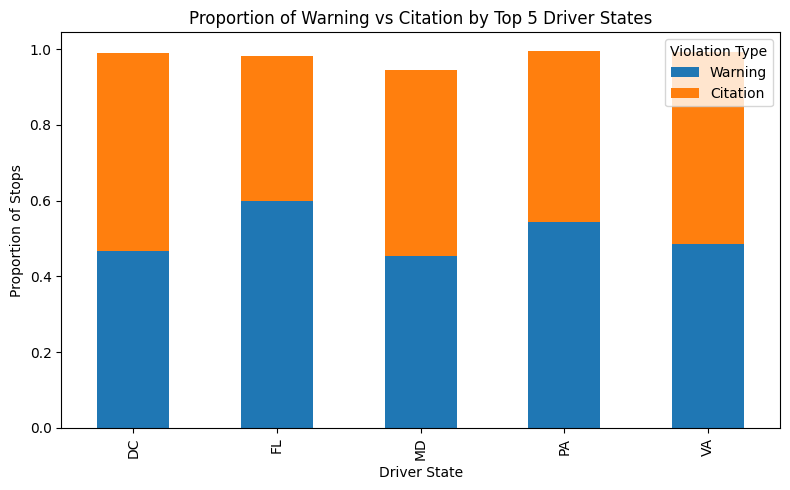

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Top 5 driver states by total violations
top_states = df["Driver State"].value_counts().head(5).index

# Filter to those states
subset = df[df["Driver State"].isin(top_states)]

# Group by state and violation type
state_violation = (
    subset.groupby(["Driver State", "Violation Type"])
    .size()
    .unstack(fill_value=0)
)

# Normalize each row to proportions
state_violation_norm = state_violation.div(state_violation.sum(axis=1), axis=0)

# Plot normalized stacked bars
state_violation_norm[["Warning","Citation"]].plot(
    kind="bar",
    stacked=True,
    figsize=(8,5),
    title="Proportion of Warning vs Citation by Top 5 Driver States"
)

plt.xlabel("Driver State")
plt.ylabel("Proportion of Stops")
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd

charge_counts = (
    df.groupby(["Charge", "Violation Type"])
    .size()
    .unstack(fill_value=0)
)

charge_counts["Total"] = charge_counts.sum(axis=1)
charge_counts["Pct_Citation"] = charge_counts["Citation"] / charge_counts["Total"]
charge_counts["Pct_Warning"]  = charge_counts["Warning"] / charge_counts["Total"]

charge_descriptions = (
    df.dropna(subset=["Charge", "Description"])
      .groupby("Charge")["Description"]
      .first()  # or .mode().iloc[0] if you want the most common one
)

# Merge back
charge_counts = charge_counts.merge(
    charge_descriptions,
    left_index=True,
    right_index=True,
    how="left"
)

charge_filtered = (
    charge_counts[charge_counts["Total"] >= 50]
    .sort_values("Pct_Citation", ascending=False)
)
charge_filtered.head(10)[["Description","Warning","Citation","Pct_Citation","Pct_Warning","Total"]]
# 21-801.1 - Speeding in a 40mph zone; 54% citation, 46% warning
# 21-201(a1) - Failure to obey traffic device instructions; 43% citation, 65% warning
# 21-707(a) - Failure to stop at stop sign; 28% citation, 72% warning
# 20-902 - DUIs and stuff. 99% citation, 1% warning
# 16-303(c) - Driving with suspended license; 

,Description,Warning,Citation,Pct_Citation,Pct_Warning,Total
Charge,,,,,,
20-104(a),FAILURE OF DRIVER INVOLVED IN ACCIDENT TO REND...,0,117,1.000000,0.000000,117
20-104(c),"FAIL OF VEH DRIVER IN ,ATTEND PROP. DAMAGE) CC...",0,171,1.000000,0.000000,171
21-902(a2),DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE,45,8982,0.995015,0.004985,9027
21-902(b1),DRIVING WHILE IMPAIRED BY ALCOHOL,69,13292,0.994836,0.005164,13361
21-902(a1),DRIVING VEHICLE WHILE UNDER THE INFLUENCE OF A...,76,13065,0.994217,0.005783,13141
16-112(e),VEH. DRIVER GIVING FALSE AND FICTITIOUS NAME T...,3,421,0.992925,0.007075,424
21-902(c1),DRIVING VEH. WHILE SO FAR IMPAIRED BY DRUGS AN...,7,965,0.992798,0.007202,972
21-904(c2),ATTEMPT BY DRIVER TO ELUDE POLICE IN OFFICIAL ...,1,118,0.991597,0.008403,119
20-108,KNOWINGLY GIVING FALSE ACCIDENT REPORT INFORMA...,1,106,0.990654,0.009346,107


In [23]:
import pandas as pd

# Subset: all 21-902 charges
dui_df = df[df["Charge"].astype(str).str.startswith("21-902")].copy()

print(f"Total 21-902 violations: {len(dui_df):,}")
print(dui_df["Violation Type"].value_counts(normalize=True))


Total 21-902 violations: 37,192
Violation Type
Citation    0.994461
Warning     0.005539
Name: proportion, dtype: float64


In [24]:
dui_summary = (
    dui_df.groupby(["Charge", "Violation Type"])
    .size()
    .unstack(fill_value=0)
)

dui_summary["Total"] = dui_summary.sum(axis=1)
dui_summary["Pct_Citation"] = dui_summary["Citation"] / dui_summary["Total"]
dui_summary["Pct_Warning"]  = dui_summary["Warning"] / dui_summary["Total"]

# Attach descriptions
desc_map = (
    dui_df.dropna(subset=["Charge","Description"])
    .groupby("Charge")["Description"]
    .first()
)
dui_summary = dui_summary.merge(desc_map, left_index=True, right_index=True, how="left")

dui_summary = dui_summary.sort_values("Pct_Citation", ascending=False)
dui_summary.head(10)


,Citation,Warning,Total,Pct_Citation,Pct_Warning,Description
Charge,,,,,,
21-902(c3),9,0,9,1.000000,0.000000,DRIVE VEH. WHILE IMPAIRED BY ALCOHOL WHILE TRA...
21-902(d2),6,0,6,1.000000,0.000000,DRIVING VEH. WHILE IMPAIRED BY CONTROLLED DANG...
21-902.1,19,0,19,1.000000,0.000000,DRIVING M/V W/I 12 HOURS AFTER ARREST FOR VIOL...
21-902(a2),8982,45,9027,0.995015,0.004985,DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE
21-902(b1),13292,69,13361,0.994836,0.005164,DRIVING WHILE IMPAIRED BY ALCOHOL
21-902(a1),13065,76,13141,0.994217,0.005783,DRIVING VEHICLE WHILE UNDER THE INFLUENCE OF A...
21-902(c1),965,7,972,0.992798,0.007202,DRIVING VEH. WHILE SO FAR IMPAIRED BY DRUGS AN...
21-902(d1),454,5,459,0.989107,0.010893,DRIVING WHILE IMPAIRED BY A CONTROLLED DANGERO...
21-902(a3),97,2,99,0.979798,0.020202,DRIVE VEH. WHILE UNDER INFLUENCE OF ALCOHOL WH...


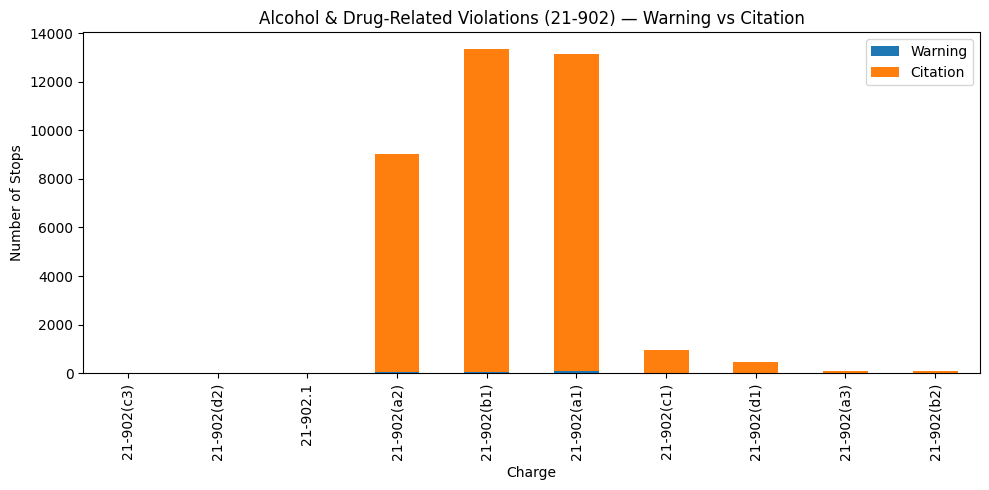

In [25]:
import matplotlib.pyplot as plt

dui_summary[["Warning","Citation"]].plot(
    kind="bar", stacked=True, figsize=(10,5),
    title="Alcohol & Drug-Related Violations (21-902) — Warning vs Citation"
)
plt.xlabel("Charge")
plt.ylabel("Number of Stops")
plt.tight_layout()
plt.show()


In [26]:
import plotly.express as px

# Filter to 21-902 warnings with valid coordinates
dui_warnings = df[
    (df["Charge"].astype(str).str.startswith("21-902")) &
    (df["Violation Type"] == "Warning") &
    df["Latitude"].notna() &
    df["Longitude"].notna()
]

# If there are many points, sample for speed
sample = dui_warnings.sample(min(3000, len(dui_warnings)), random_state=42)

# Plot
fig = px.scatter_map(
    sample,
    lat="Latitude", lon="Longitude",
    hover_name="Description",
    hover_data={"Charge":True, "SubAgency":True},
    title="Alcohol/Drug-Related (21-902) Warnings by Location"
)
fig.show()


In [27]:
# 21-1124% : Using phone while driving
dui_warnings = df[
    (df["Charge"].astype(str).str.startswith("21-1124")) &
    (df["Violation Type"] == "Warning") &
    df["Latitude"].notna() &
    df["Longitude"].notna()
]

# If there are many points, sample for speed
sample = dui_warnings.sample(min(3000, len(dui_warnings)), random_state=42)

# Plot
fig = px.scatter_map(
    sample,
    lat="Latitude", lon="Longitude",
    hover_name="Description",
    hover_data={"Charge":True, "SubAgency":True},
    title="Mobile Device Related (21-1124) Warnings by Location"
)
fig.to_html("21-1124_warnings_map.html")
fig.show()

In [28]:
# 21-1124% : Using phone while driving
dui_warnings = df[
    (df["Charge"].astype(str).str.startswith("21-1124")) &
    (df["Violation Type"] == "Citation") &
    df["Latitude"].notna() &
    df["Longitude"].notna()
]

# If there are many points, sample for speed
sample = dui_warnings.sample(min(3000, len(dui_warnings)), random_state=42)

# Plot
fig = px.scatter_map(
    sample,
    lat="Latitude", lon="Longitude",
    hover_name="Description",
    hover_data={"Charge":True, "SubAgency":True},
    title="Mobile Device Related (21-1124) Citations by Location"
)
fig.to_html("21-1124_citations_map.html")
fig.show()

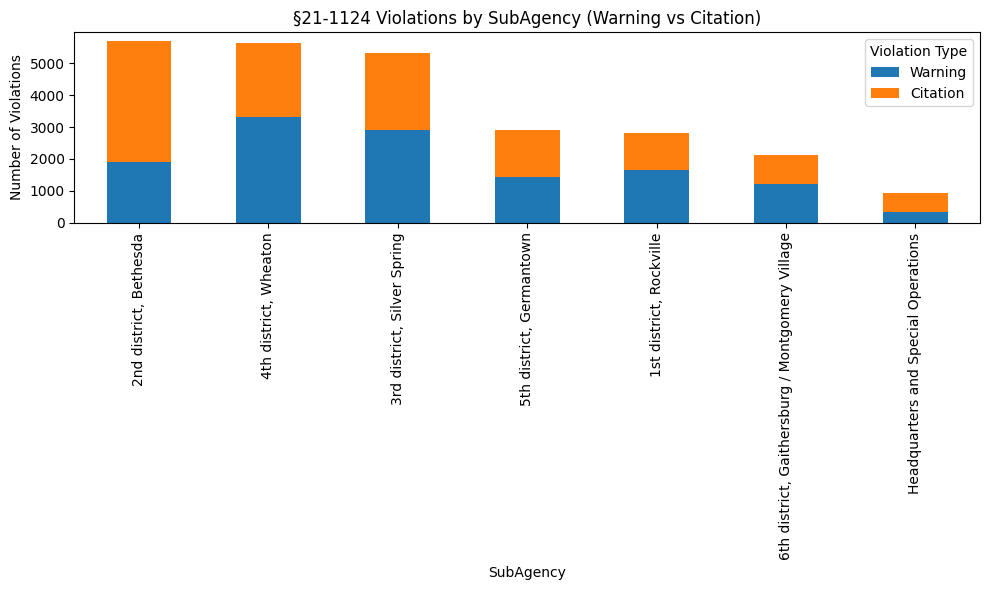

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter to §21-1124 charges
v1124 = df[df["Charge"].astype(str).str.startswith("21-1124")].copy()

# Group by SubAgency × Violation Type
agency_violations = (
    v1124.groupby(["SubAgency", "Violation Type"])
    .size()
    .unstack(fill_value=0)
)

# Sort by total number of stops (descending)
agency_violations = agency_violations.assign(
    Total = agency_violations.sum(axis=1)
).sort_values("Total", ascending=False)

# Plot stacked bars
agency_violations[["Warning","Citation"]].plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    title="§21-1124 Violations by SubAgency (Warning vs Citation)"
)
plt.xlabel("SubAgency")
plt.ylabel("Number of Violations")
plt.tight_layout()
plt.show()


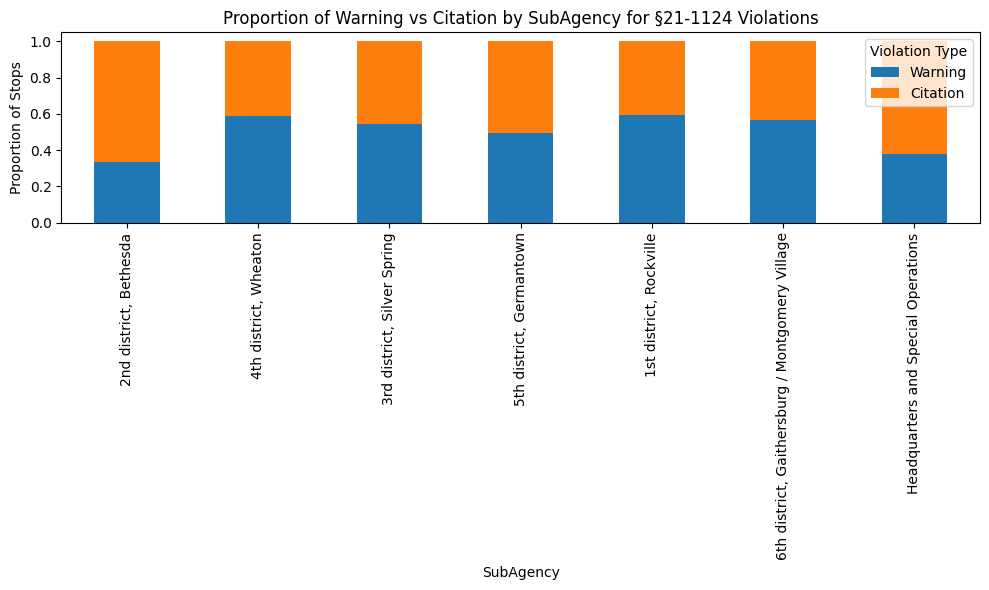

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter to §21-1124 charges
v1124 = df[df["Charge"].astype(str).str.startswith("21-1124")].copy()

# Group by SubAgency × Violation Type
agency_violations = (
    v1124.groupby(["SubAgency", "Violation Type"])
    .size()
    .unstack(fill_value=0)
)

# Normalize each subagency to proportions
agency_violations_norm = agency_violations.div(agency_violations.sum(axis=1), axis=0)

# Sort by total count (to keep order consistent with top activity)
agency_violations_norm = agency_violations_norm.loc[
    agency_violations.sum(axis=1).sort_values(ascending=False).index
]

# Plot normalized stacked bars
agency_violations_norm[["Warning", "Citation"]].plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    title="Proportion of Warning vs Citation by SubAgency for §21-1124 Violations"
)
plt.xlabel("SubAgency")
plt.ylabel("Proportion of Stops")
plt.tight_layout()
plt.show()


C:\Users\diazk\AppData\Local\Temp\ipykernel_3540\2355199540.py:10: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



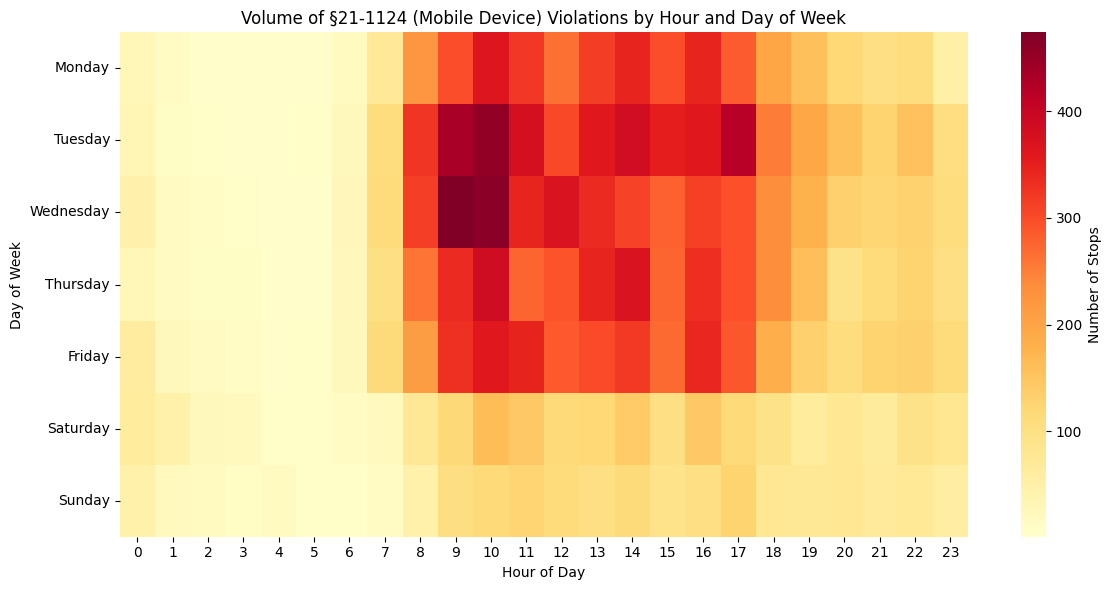

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Filter for mobile device use (section 21-1124) ---
mobile_df = df[df["Charge"].astype(str).str.startswith("21-1124")].copy()

# --- Parse time and date ---
mobile_df["Date Of Stop"] = pd.to_datetime(mobile_df["Date Of Stop"], errors="coerce")
mobile_df["Time Of Stop"] = pd.to_datetime(mobile_df["Time Of Stop"], errors="coerce")
mobile_df["Hour"] = mobile_df["Time Of Stop"].dt.hour
mobile_df["DayOfWeek"] = mobile_df["Date Of Stop"].dt.day_name()

# --- Compute stop counts ---
volume = (
    mobile_df.groupby(["DayOfWeek", "Hour"])
    .size()
    .reset_index(name="Count")
)

# Reorder weekdays for readability
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
volume["DayOfWeek"] = pd.Categorical(volume["DayOfWeek"], categories=day_order, ordered=True)

# Pivot to create a matrix for the heatmap
heat_data = volume.pivot(index="DayOfWeek", columns="Hour", values="Count")

# --- Plot heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(
    heat_data,
    cmap="YlOrRd",
    cbar_kws={"label": "Number of Stops"}
)
plt.title("Volume of §21-1124 (Mobile Device) Violations by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


C:\Users\diazk\AppData\Local\Temp\ipykernel_3540\4175110365.py:10: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



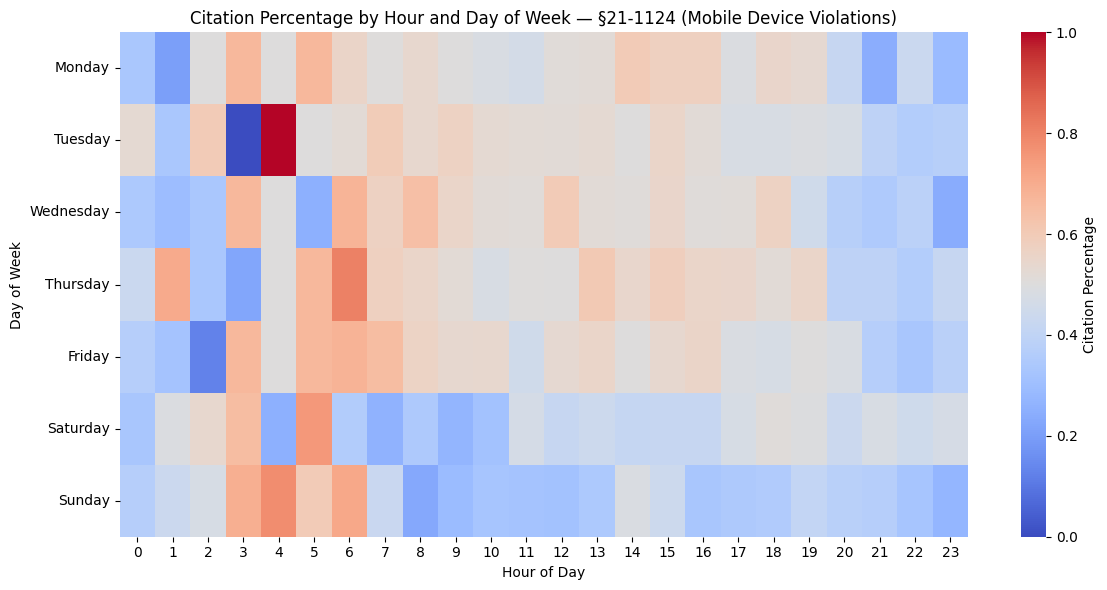

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Filter for mobile device use (section 21-1124) ---
mobile_df = df[df["Charge"].astype(str).str.startswith("21-1124")].copy()

# --- Parse time and date fields ---
mobile_df["Date Of Stop"] = pd.to_datetime(mobile_df["Date Of Stop"], errors="coerce")
mobile_df["Time Of Stop"] = pd.to_datetime(mobile_df["Time Of Stop"], errors="coerce")
mobile_df["Hour"] = mobile_df["Time Of Stop"].dt.hour
mobile_df["DayOfWeek"] = mobile_df["Date Of Stop"].dt.day_name()

# --- Create binary flag for citation ---
mobile_df["isCitation"] = (mobile_df["Violation Type"] == "Citation").astype(int)

# --- Compute citation rate ---
citation_rate = (
    mobile_df.groupby(["DayOfWeek", "Hour"])["isCitation"]
    .mean()
    .reset_index()
)

# Reorder weekdays
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
citation_rate["DayOfWeek"] = pd.Categorical(citation_rate["DayOfWeek"], categories=day_order, ordered=True)

# Pivot for heatmap
heat_data = citation_rate.pivot(index="DayOfWeek", columns="Hour", values="isCitation")

# --- Plot heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(
    heat_data,
    cmap="coolwarm",
    cbar_kws={"label":"Citation Percentage"},
    vmin=0, vmax=1
)
plt.title("Citation Percentage by Hour and Day of Week — §21-1124 (Mobile Device Violations)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


C:\Users\diazk\AppData\Local\Temp\ipykernel_3540\2013815979.py:10: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



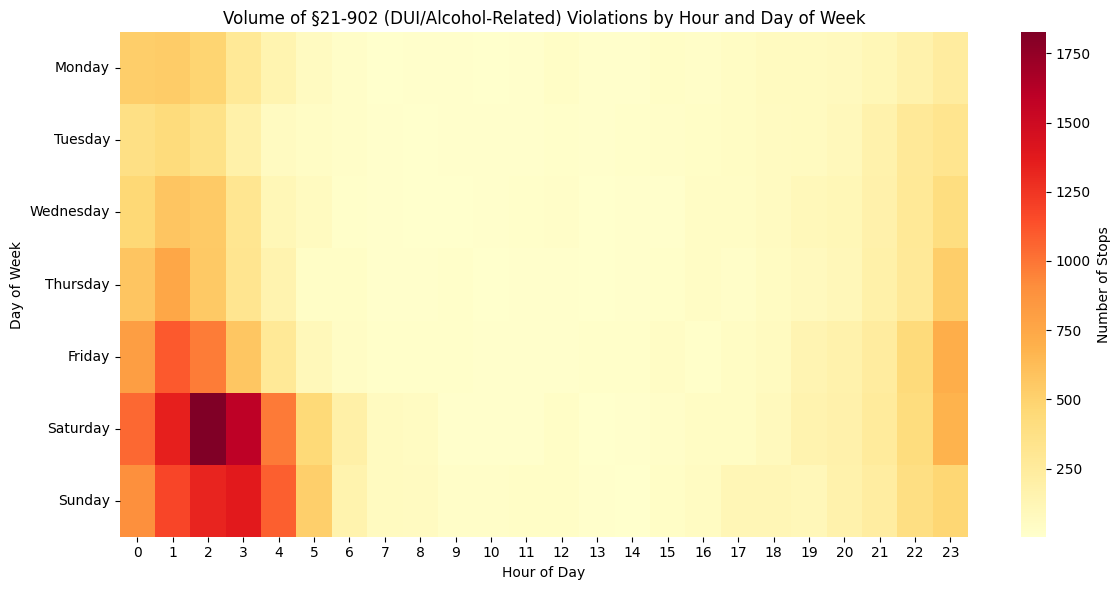

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Filter for DUI-related charges (section 21-902) ---
dui_df = df[df["Charge"].astype(str).str.startswith("21-902")].copy()

# --- Parse time and date ---
dui_df["Date Of Stop"] = pd.to_datetime(dui_df["Date Of Stop"], errors="coerce")
dui_df["Time Of Stop"] = pd.to_datetime(dui_df["Time Of Stop"], errors="coerce")
dui_df["Hour"] = dui_df["Time Of Stop"].dt.hour
dui_df["DayOfWeek"] = dui_df["Date Of Stop"].dt.day_name()

# --- Compute stop counts ---
volume = (
    dui_df.groupby(["DayOfWeek", "Hour"])
    .size()
    .reset_index(name="Count")
)

# Reorder weekdays for readability
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
volume["DayOfWeek"] = pd.Categorical(volume["DayOfWeek"], categories=day_order, ordered=True)

# Pivot for heatmap
heat_data = volume.pivot(index="DayOfWeek", columns="Hour", values="Count")

# --- Plot heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(
    heat_data,
    cmap="YlOrRd",
    cbar_kws={"label": "Number of Stops"}
)
plt.title("Volume of §21-902 (DUI/Alcohol-Related) Violations by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


In [34]:
# Charges with at least 50 stops
common_charges = (
    df["Charge"].value_counts()
    [df["Charge"].value_counts() >= 50]
    .index.tolist()
)

key_stems = [
    "21-902",    # DUIs
    "21-1124",   # mobile device
    "21-801",    # speeding
    "21-201",    # traffic device instructions
    "21-707",    # stop sign violation
]

target_charges = []
for c in common_charges:
    if any(c.startswith(stem) for stem in key_stems):
        target_charges.append(c)

print("Identified target charges:")
target_charges


Identified target charges:


['21-801.1',
 '21-201(a1)',
 '21-707(a)',
 '21-1124.2(d2)',
 '21-801(a)',
 '21-902(b1)',
 '21-902(a1)',
 '21-801(b)',
 '21-902(a2)',
 '21-1124.1(b)',
 '21-201(a2)',
 '21-902(c1)',
 '21-902(d1)',
 '21-707(b)',
 '21-801(h)',
 '21-707(c)',
 '21-1124.2(c2)',
 '21-1124.2(c1)',
 '21-902(b2)',
 '21-902(a3)',
 '21-801(e)']

In [35]:
df_sub = df[df["Charge"].isin(target_charges)].copy()
print("Rows in target subset:", len(df_sub))
print("Charges included:", sorted(df_sub["Charge"].unique()))

Rows in target subset: 343135
Charges included: ['21-1124.1(b)', '21-1124.2(c1)', '21-1124.2(c2)', '21-1124.2(d2)', '21-201(a1)', '21-201(a2)', '21-707(a)', '21-707(b)', '21-707(c)', '21-801(a)', '21-801(b)', '21-801(e)', '21-801(h)', '21-801.1', '21-902(a1)', '21-902(a2)', '21-902(a3)', '21-902(b1)', '21-902(b2)', '21-902(c1)', '21-902(d1)']


Race
HISPANIC           0.613452
BLACK              0.509098
WHITE              0.484341
OTHER              0.479434
ASIAN              0.472869
NATIVE AMERICAN    0.391515
Name: Violation Type, dtype: float64

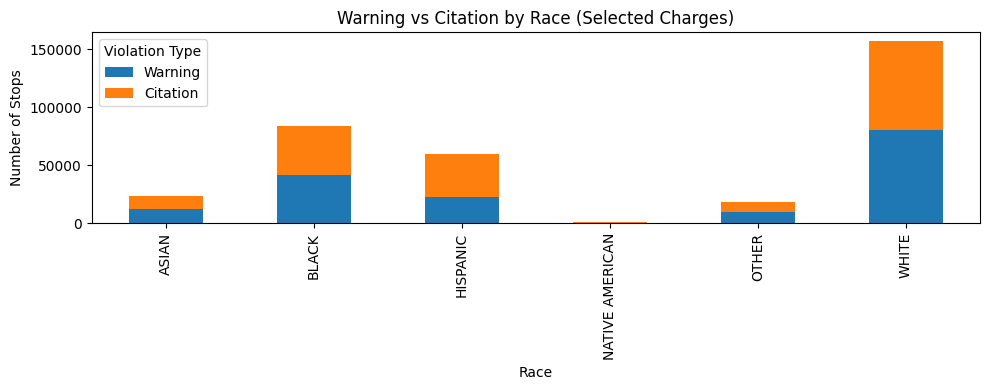

In [36]:
# %% Race vs Citation Rate

race_counts = (
    df_sub.groupby("Race")["Violation Type"]
    .value_counts()
    .unstack(fill_value=0)
)

race_pct = (
    df_sub.groupby("Race")["Violation Type"]
    .apply(lambda x: (x == "Citation").mean())
    .sort_values(ascending=False)
)

display(race_pct)
race_counts[["Warning","Citation"]].plot(
    kind="bar", stacked=True, figsize=(10,4),
    title="Warning vs Citation by Race (Selected Charges)"
)
plt.ylabel("Number of Stops")
plt.tight_layout()
plt.show()


Cleaned_Make
KAWASAKI           0.651282
MERCURY            0.582353
HARLEY DAVIDSON    0.576577
HINO               0.575342
PLYMOUTH           0.566116
RAM                0.563107
MASERATI           0.559322
ISUZU              0.555667
YAMAHA             0.553191
DODGE              0.544474
FREIGHTLINER       0.541284
MITSUBISHI         0.538573
CHEVROLET          0.536985
SUZUKI             0.534669
NISSAN             0.533121
FORD               0.532530
BMW                0.532335
PORSCHE            0.532110
SAAB               0.531250
HUMMER             0.531250
SCION              0.531034
PETERBILT          0.529412
GMC                0.526291
VOLKSWAGEN         0.525104
CADILLAC           0.524715
PONTIAC            0.524523
AUDI               0.523884
MINI               0.522264
INFINITI           0.520744
LINCOLN            0.520021
LAND ROVER         0.514161
MERCEDES-BENZ      0.512686
CHRYSLER           0.512229
JEEP               0.511652
SATURN             0.508074
ACURA  

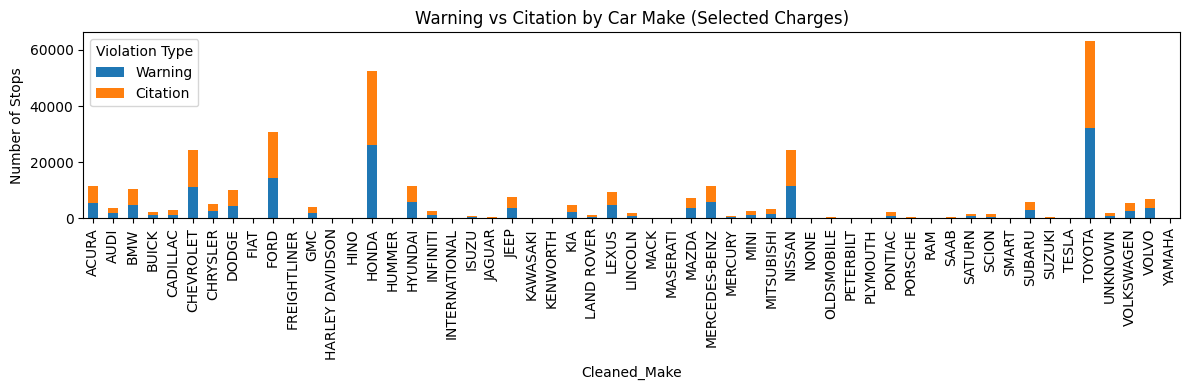

In [37]:
# %% Car Make vs Citation Rate

make_counts = (
    df_sub.groupby("Cleaned_Make")["Violation Type"]
    .value_counts()
    .unstack(fill_value=0)
)

# Avoid noise — only makes with 50+ observations
major_makes = make_counts[make_counts.sum(axis=1) >= 50]

make_pct = (
    major_makes["Citation"] / major_makes.sum(axis=1)
).sort_values(ascending=False)

display(make_pct)

major_makes[["Warning","Citation"]].plot(
    kind="bar", stacked=True, figsize=(12,4),
    title="Warning vs Citation by Car Make (Selected Charges)"
)
plt.ylabel("Number of Stops")
plt.tight_layout()
plt.show()


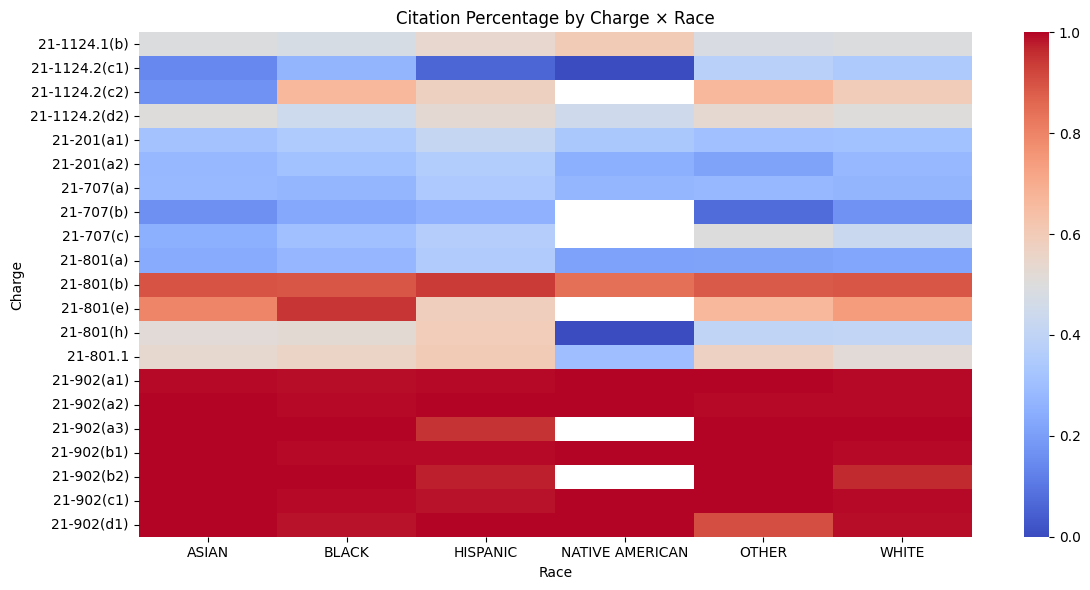

In [38]:
# %% Citation % by Race for each Charge

race_charge = (
    df_sub.groupby(["Charge","Race"])["Violation Type"]
    .apply(lambda x: (x == "Citation").mean())
    .unstack(fill_value=np.nan)
)

plt.figure(figsize=(12,6))
sns.heatmap(
    race_charge, cmap="coolwarm", vmin=0, vmax=1,
    annot=False
)
plt.title("Citation Percentage by Charge × Race")
plt.xlabel("Race")
plt.ylabel("Charge")
plt.tight_layout()
plt.show()


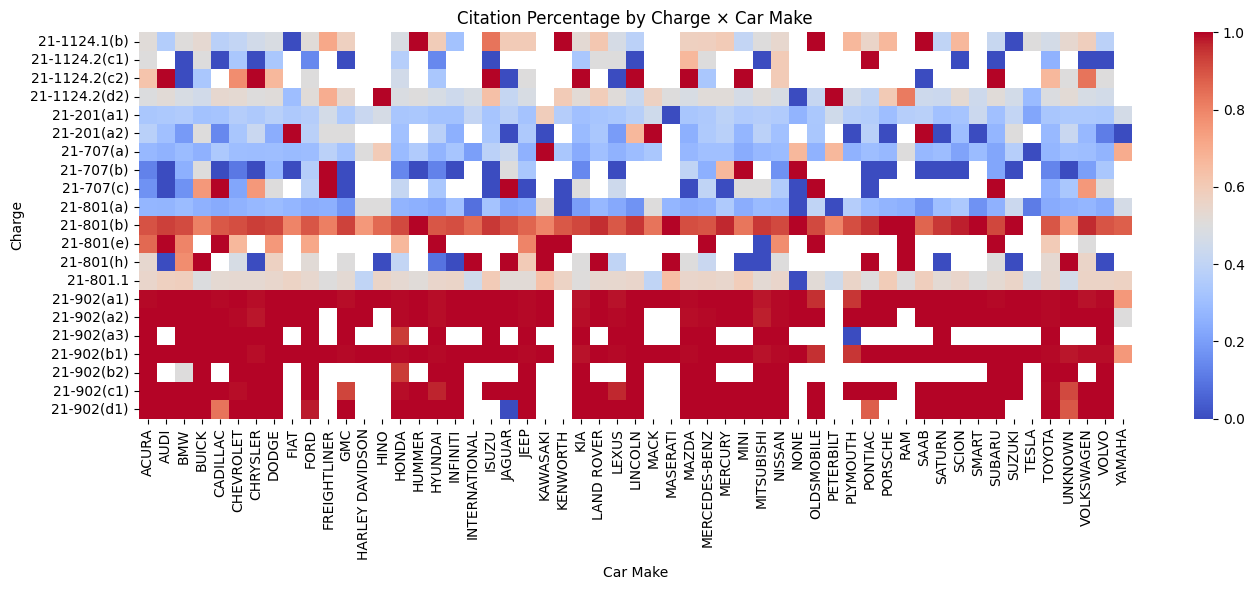

In [39]:
# Filter to major makes again
df_major = df_sub[df_sub["Cleaned_Make"].isin(major_makes.index)]

make_charge = (
    df_major.groupby(["Charge","Cleaned_Make"])["Violation Type"]
    .apply(lambda x: (x == "Citation").mean())
    .unstack(fill_value=np.nan)
)

plt.figure(figsize=(14,6))
sns.heatmap(
    make_charge, cmap="coolwarm", vmin=0, vmax=1,
    annot=False
)
plt.title("Citation Percentage by Charge × Car Make")
plt.xlabel("Car Make")
plt.ylabel("Charge")
plt.tight_layout()
plt.show()


In [40]:
# Which charges have strongest race disparity?

race_var = race_charge.var(axis=1).sort_values(ascending=False)
print("Charges with highest variance in citation rate by Race:")
display(race_var.head(10))


Charges with highest variance in citation rate by Race:


Charge
21-801(h)        0.045209
21-1124.2(c2)    0.043835
21-1124.2(c1)    0.023915
21-801(e)        0.019052
21-801.1         0.011676
21-707(c)        0.009847
21-707(b)        0.005072
21-801(a)        0.003006
21-201(a2)       0.002463
21-1124.1(b)     0.002296
dtype: float64

In [41]:
# Which charges have strongest make disparity?

make_var = make_charge.var(axis=1).sort_values(ascending=False)
print("Charges with highest variance in citation rate by Car Make:")
display(make_var.head(10))


Charges with highest variance in citation rate by Car Make:


Charge
21-801(h)        0.140866
21-1124.2(c2)    0.123601
21-707(c)        0.119747
21-707(b)        0.083588
21-1124.2(c1)    0.076611
21-801(e)        0.062015
21-201(a2)       0.057415
21-1124.1(b)     0.043656
21-902(a3)       0.041603
21-902(d1)       0.027816
dtype: float64